# NASA Turbofan Engine Degradation Analysis - IoTFuse 2019

## Install the required libraries using `pip install`

In [2]:
!pip install matplotlib==1.5.1
!pip install pandas==0.18
!pip install numpy==1.11.3
!pip install seaborn==0.7.1
!pip install scikit-learn==0.18.1
!pip install plotly==3.1.0

## Import the packages

In [1]:
import plotly
plotly.tools.set_credentials_file(username='', api_key='')
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 16)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# load necessary packages and view available data
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()
np.random.seed(7)  
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
import itertools

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning:

Matplotlib is building the font cache using fc-list. This may take a moment.



/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.



In [4]:
pd.__version__

'0.18.0'

## Step 1a: Load the datasets from the workspace

- if you're using Notebooks on Azure ML Studio, use the following to load your dataset
- make sure you've uploaded the data to your workspace first!

In [2]:
import azureml
from azureml import Workspace
ws = Workspace()
trainData = ws.datasets['RUL_train_FD001.csv'].to_dataframe()

## Step 1b: Load a local dataset

- if you're working locally, use the following to load your dataset
- make sure you're pointing to the directory where the data is stored

In [ ]:
trainData = pd.read_csv('../data/CMAPSSData/raw_data/train_FD001.txt', sep=" ", header=None)
testData = pd.read_csv('../data/CMAPSSData/raw_data/test_FD001.txt', sep=" ", header=None)

## Step 2: Transform your data

- Delete any null columns
- Set datatypes
- Change column names to something more readable
- Calculate Remaining Useful Life (RUL)
- Remove unnecessary columns

### I. Delete any null columns

In [3]:
trainData.drop(trainData.columns[[26, 27]], axis=1, inplace=True)

### II. Set datatypes

In [4]:
trainData = trainData.astype(np.float32)

### III. Change column names to something more readable

In [5]:
indexCols =  ["UnitNumber","Cycle"]
operationalSettingCols = ["Setting1","Setting2","Setting3"]
sensorCols =['FanInletTemp','LPCOutletTemp','HPCOutletTemp','LPTOutletTemp','FanInletPres','BypassDuctPres','TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed','EnginePresRatio','StaticHPCOutletPres','FuelFlowRatio','CorrFanSpeed','CorrCoreSpeed','BypassRatio','BurnerFuelAirRatio','BleedEnthalpy','DemandFanSpeed','DemandCorrFanSpeed','HPTCoolantBleed','LPTCoolantBleed']
cols = indexCols + operationalSettingCols + sensorCols

trainData.columns = cols

### IV. Calculate Remaining Useful Life (RUL)

- group the data by `UnitNumber`
- evaluate the maximum number of cycles and create a new column called `MaxCycles`
- calculate `RUL` for every instance: RUL(t) = MaxCycles - Cycle(t)

In [6]:
maxCycles = trainData.groupby('UnitNumber')['Cycle'].max().reset_index()
maxCycles.columns = ['UnitNumber', 'MaxCycles']
mergedTrain = trainData.merge(maxCycles, left_on='UnitNumber', right_on='UnitNumber', how='inner')
RUL = mergedTrain["MaxCycles"] - mergedTrain["Cycle"]
trainData = mergedTrain["RUL"] = RUL

In [7]:
# remove unnecessary columns
trainData = mergedTrain.drop("MaxCycles", axis=1)

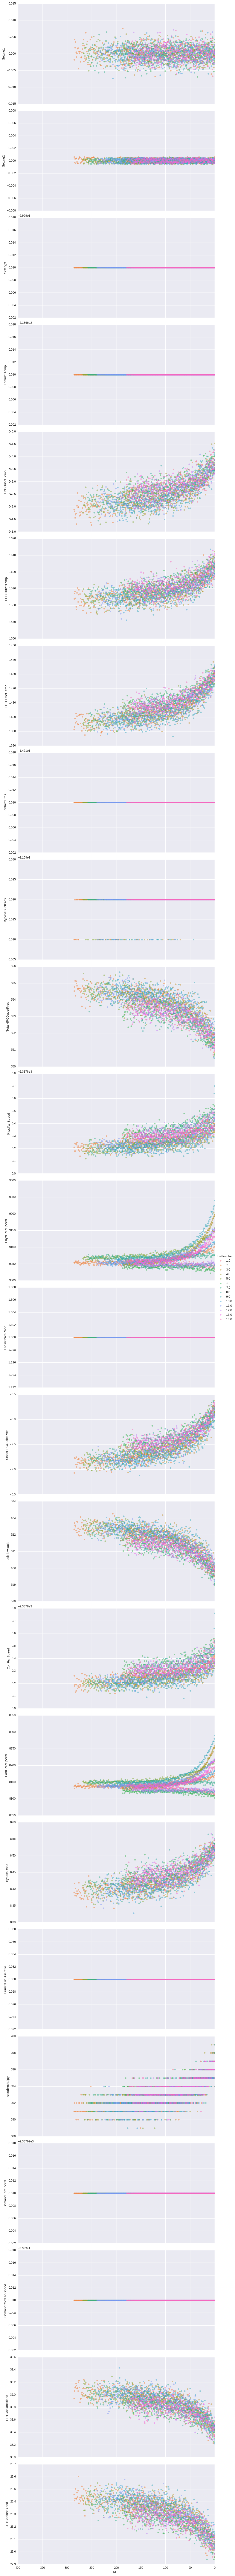

In [8]:
# visualize how features vary with RUL
featurePlot = sns.PairGrid(data=trainData.query('UnitNumber < 15'),
                       x_vars='RUL',
                       y_vars=operationalSettingCols+sensorCols,
                       hue="UnitNumber", size=5, aspect=2)
featurePlot = featurePlot.map(plt.scatter, alpha=0.5)
featurePlot = featurePlot.set(xlim=(400,0))
featurePlot = featurePlot.add_legend()

In [ ]:
OpSettingsPlot = sns.pairplot(data=trainData.query('UnitNumber < 15'),
                              x_vars=operationalSettingCols,
                              y_vars=sensorCols,
                              hue="UnitNumber", size=4, aspect=2)

## Step 3: Feature Extraction

- Remove features that can potentially cause target leakage
- Evaluate feature importance using random forest regression
- Remove redundant features based on above analysis

### I. Remove features that can potentially cause target leakage

In [ ]:
leakageCols = ['UnitNumber', 'Cycle', 'Setting1', 'Setting2', 'Setting3']  
leakageDroppedTrainData = trainData.drop(leakageCols, axis=1)

### II. Evaluate feature importance using random forest regression

In [ ]:
# set up features and target variable 
FIY = leakageDroppedTrainData['RUL']
FIX = leakageDroppedTrainData.drop(['RUL'], axis = 1)

randomForestRegressor = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 20)
randomForestRegressor.fit(FIX, FIY)
predY = randomForestRegressor.predict(FIX)

In [ ]:
# graph feature importance
featureImportance = randomForestRegressor.feature_importances_
featureIDs = np.argsort(featureImportance)[::-1]
featureNames = FIX.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature Importance", fontsize = 20)
plt.bar(range(FIX.shape[1]), featureImportance[featureIDs], color="b", align="center")
labelSet = {id:label for id,label in zip(range(len(featureNames)),featureNames)}
plt.xticks(range(FIX.shape[1]), [labelSet[id] for id in featureIDs])
plt.xticks(rotation=-60)
plt.xlim([-1, FIX.shape[1]])
plt.ylabel("Feature Importance Score", fontsize = 18)
plt.xlabel("Feature", fontsize = 18)
plt.show()
# list feature importance
important_features = pd.Series(data=randomForestRegressor.feature_importances_,index=FIX.columns)
important_features.sort_values(ascending=False,inplace=True)
display(important_features)

### III. Remove redundant features based on above analysis

In [ ]:
redundantCols = list(important_features[important_features<0.0001].index)
print(redundantCols)

## Step 4: Solve a Regression Problem

- can we predict RUL (in cycles)?

In [ ]:
regTrainData = leakageDroppedTrainData.drop(redundantCols, axis = 1)
regTestData = leakageDroppedTestData.drop(redundantCols, axis=1)

# impute data if needed

numericData = regTrainData.select_dtypes(exclude=['object'])
for col in numericData.columns:
    if pd.isnull(numericData[col]).sum() > 0:
        numericData["%s_mi" % (col)] = pd.isnull(numericData[col])
        median = numericData[col].median()
        numericData[col] = numericData[col].apply(lambda x: median if pd.isnull(x) else x)

# set up features and target variable 

RY = numericData['RUL']
RX = numericData.drop(['RUL'], axis = 1)

In [ ]:
# random forest regression
trainX, testX, trainY, testY = train_test_split(RX, RY, test_size=0.2, random_state=7)

randomForestRegressor = ensemble.RandomForestRegressor()
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),
                           ('model', randomForestRegressor) ])
# model tuning
test_min_samples_leaf = [2, 10, 25, 50, 100]
test_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
optimizedRandomForestRegressor = GridSearchCV(estimator=pipeline,
                                              cv=model_selection.KFold(5),
                                              param_grid=dict(model__min_samples_leaf = test_min_samples_leaf, model__max_depth = test_max_depth),
                                              scoring = 'neg_mean_squared_error',
                                              verbose = 1,
                                              n_jobs = -1)
optimizedRandomForestRegressor.fit(trainX, trainY)
print(optimizedRandomForestRegressor.best_estimator_)
predY = optimizedRandomForestRegressor.predict(testX)
print("Mean Squared Error: ", mean_squared_error(testY, predY))
print("Mean Absolute Error: ", mean_absolute_error(testY, predY))
print("Coefficient of Determination (R2): ", r2_score(testY, predY))

In [ ]:
# plot actual vs predicted Remaining Useful Life
trace0 = go.Scatter(
    x = testY,
    y = predY,
    mode = 'markers',
    name = 'RUL',
    marker = dict(color='rgb(22, 96, 167)')
)
trace1 = go.Scatter(
    x = testY,
    y = testY,
    name = 'Reference',
    line = dict(
        color = ('rgba(0, 0, 0, 0.2)'),
        width = 4,
        dash = 'dash')
)
data = [trace1,trace0]
layout = go.Layout(
    title = 'Actual vs. Predicted Useful Remaining Life (Cycles)',
    xaxis=dict(title='Actual Remaining Useful Life'),
    yaxis=dict(title='Predicted Remaining Useful Life'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Step 5: Solve a Classification Problem

- can we identify when unit is within its last 15 cycles?

In [ ]:
leakageDroppedTrainData['15_Cycles'] = np.where(leakageDroppedTrainData['RUL'] <= 15, 1, 0 )
# remove redundant sensors and RUL
binaryTrainData = leakageDroppedTrainData.drop(redundantCols+['RUL'], axis = 1)

# impute data if needed
numericData = binaryTrainData.select_dtypes(exclude=['object'])
for col in numericData.columns:
    if pd.isnull(numericData[col]).sum() > 0:
        numericData["%s_mi" % (col)] = pd.isnull(numericData[col])
        median = numericData[col].median()
        numericData[col] = numericData[col].apply(lambda x: median if pd.isnull(x) else x)
Y = numericData['15_Cycles']
X = numericData.drop(['15_Cycles'], axis = 1)

In [ ]:
# random forest classification
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=7)
randomForestClassifier = ensemble.RandomForestClassifier()
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler()),
                           ('model', randomForestClassifier) ])
# model tuning
test_min_samples_leaf = [2, 25, 50]
test_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimizedRandomForestClassifier = GridSearchCV(estimator=pipeline,
                            cv=model_selection.KFold(5),
                            param_grid =dict(model__min_samples_leaf = test_min_samples_leaf, model__max_depth = test_max_depth),
                            scoring = 'roc_auc',
                            verbose = 1,
                            n_jobs = -1)
optimizedRandomForestClassifier.fit(trainX, trainY)
predY = optimizedRandomForestClassifier.predict(testX)
predYProb = optimizedRandomForestClassifier.predict_proba(testX)[:, 1]
print(optimizedRandomForestClassifier.best_estimator_)

In [ ]:
print("Confusion Matrix")
confusionMatrix = confusion_matrix(testY, predY)
print(confusionMatrix)
precisionScore = precision_score(testY, predY)
accuracyScore = accuracy_score(testY, predY)
recallScore = recall_score(testY, predY)
print("Precision: "+"{:.1%}".format(precisionScore))
print("Accuracy: "+"{:.1%}".format(accuracyScore))
print("Recall: "+"{:.1%}".format(recallScore))
print(classification_report(testY, predY))

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 36}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [14,10]

fpr, tpr, threshold = metrics.roc_curve(testY, predYProb)
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC curve',fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label',fontsize=18)
    plt.tight_layout()

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [10,10]
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(confusionMatrix, normalize = True, classes=["Failure within 15 days","No failure"])

In [ ]:
trace0 = go.Scatter(
    x = fpr,
    y = tpr,
    mode = 'lines',
    name = 'AUC = %0.2f' % roc_auc,
)
trace1 = go.Scatter(
    x = [0,1],
    y = [0,1],
    name = 'Reference',
    line = dict(
        color = ('rgba(255, 0, 0, 0.5)'),
        width = 4,
        dash = 'dash')
)
data = [trace0,trace1]
layout = go.Layout(
    title = 'ROC Curve',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Step 4: Solve a Multi-class Classification Problem

- can we predict whether a unit will fail within window 1, window 2 or window 3?

In [ ]:
# remove redundant sensor values
multiclassTrainData = leakageDroppedTrainData.drop(redundantCols, axis = 1)

conditions = [
    (multiclassTrainData['RUL'] <= 15),
    (multiclassTrainData['RUL'] > 15) & (multiclassTrainData['RUL'] <= 30),
    (multiclassTrainData['RUL'] > 30)]
choices = [2,1,0]
multiclassTrainData['label'] = np.select(conditions, choices, default=0)
multiclassTrainData = multiclassTrainData.drop(['RUL'],axis=1)

# set up features and target variable 

MCY = multiclassTrainData['label']
MCX = multiclassTrainData.drop(['label'], axis = 1)

In [ ]:
# multi-class random forest classification
trainX, testX, trainY, testY = train_test_split(MCX, MCY, test_size=0.2, random_state=7)

randomForestClassifier = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
randomForestClassifier.fit(trainX, trainY)
predY = randomForestClassifier.predict(testX)
predYProb = randomForestClassifier.predict_proba(testX)[:, 1]

In [ ]:
print(testY.value_counts())
print("Confusion Matrix")
confusionMatrix = confusion_matrix(testY, predY)
print(confusionMatrix)
precisionScore = precision_score(testY, predY, average='weighted')
accuracyScore = accuracy_score(testY, predY)
recallScore = recall_score(testY, predY, average='weighted')
print("Precision: "+"{:.1%}".format(precisionScore))
print("Accuracy: "+"{:.1%}".format(accuracyScore))
print("Recall: "+"{:.1%}".format(recallScore))
print(classification_report(testY, predY))

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [10,10]
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(confusionMatrix, normalize = True, classes=["No failure within 30 cycles","Failure within 15-30 cycles","Failure within 15 cycles"])

In [61]:
# feature engineering
# add rolling mean and standard deviation

windowSize = 5 
w0 = 15
w1 = 30
redundantCols = ['BurnerFuelAirRatio','EnginePresRatio','DemandFanSpeed','FanInletPres','DemandCorrFanSpeed','FanInletTemp']
newSensorCols = [c for c in sensorCols if c not in redundantCols]
FETrainData = trainData[['UnitNumber','Cycle','RUL']+newSensorCols]
#FETrainData = FETrainData[FETrainData['UnitNumber']==4]
# apply rolling mean window
MASensorCols = [c+'_MA' for c in newSensorCols]
SDSensorCols = [c+'_SD' for c in newSensorCols]
print(newSensorCols)
grouped = FETrainData.groupby('UnitNumber')
# for pandas version 0.18, use this:
for col in newSensorCols:
    FETrainData['%s_MA'%col] = grouped[col].apply(lambda g: g.rolling(window=windowSize, min_periods=0).mean())
    FETrainData['%s_SD'%col] = grouped[col].apply(lambda g: g.rolling(window=windowSize, min_periods=0).mean())

conditions = [
    (FETrainData['RUL'] <= w0),
    (FETrainData['RUL'] > w0) & (FETrainData['RUL'] <= w1),
    (FETrainData['RUL'] > w1)]
choices = [2,1,0]
FETrainData['label'] = np.select(conditions, choices, default=0)
FETrainData = FETrainData.dropna() # don't drop leakage values yet; we need them later

# set up features and target variable 

FEMCY = FETrainData['label']
FEMCX = FETrainData.drop(['label'], axis = 1)


['LPCOutletTemp', 'HPCOutletTemp', 'LPTOutletTemp', 'BypassDuctPres', 'TotalHPCOutletPres', 'PhysFanSpeed', 'PhysCoreSpeed', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio', 'BleedEnthalpy', 'HPTCoolantBleed', 'LPTCoolantBleed']


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



"\nFETrainData[SDSensorCols] = FETrainData.groupby('UnitNumber')[newSensorCols].apply(lambda g: g.rolling(window=windowSize, min_periods=int(windowSize/2)).std())\nconditions = [\n    (FETrainData['RUL'] <= w0),\n    (FETrainData['RUL'] > w0) & (FETrainData['RUL'] <= w1),\n    (FETrainData['RUL'] > w1)]\nchoices = [2,1,0]\nFETrainData['label'] = np.select(conditions, choices, default=0)\nFETrainData = FETrainData.dropna() # don't drop leakage values yet; we need them later\n\n# set up features and target variable \n\nFEMCY = FETrainData['label']\nFEMCX = FETrainData.drop(['label'], axis = 1)\n"

In [ ]:
# multi-class random forest classification
trainX, testX, trainY, testY = train_test_split(FEMCX, FEMCY, test_size=0.2, random_state=7)
LDTrainX = trainX.drop(['UnitNumber','Cycle','RUL'],axis=1)
LDTestX = testX.drop(['UnitNumber','Cycle','RUL'],axis=1)

randomForestClassifier = ensemble.RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
randomForestClassifier.fit(LDTrainX, trainY)
predY = randomForestClassifier.predict(LDTestX)
predYProb = randomForestClassifier.predict_proba(LDTestX)[:, 1]

In [ ]:
print(testY.value_counts())
print("Confusion Matrix")
confusionMatrix = confusion_matrix(testY, predY)
print(confusionMatrix)
precisionScore = precision_score(testY, predY, average='weighted')
accuracyScore = accuracy_score(testY, predY)
recallScore = recall_score(testY, predY, average='weighted')
print("Precision: "+"{:.1%}".format(precisionScore))
print("Accuracy: "+"{:.1%}".format(accuracyScore))
print("Recall: "+"{:.1%}".format(recallScore))
print(classification_report(testY, predY))

In [ ]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = [10,10]
plt.rcParams["axes.grid"] = False
plot_confusion_matrix(confusionMatrix, normalize = True, classes=["No failure within %d cycles"%w1,"Failure within %d-%d cycles"%(w0,w1),"Failure within %d cycles"%w0])

## Step 5: Calculate Metrics

- calculate how many more cycles can be gained by scheduling maintenance after 1st warning, etc.

In [ ]:
# calculate percent uptime gain
# assume default maintenance is scheduled every 125 cycles

# calculate total cycles run prior to default maintenance
scheduledMaintenance = 125 # i.e. each unit runs this many times before maintenance is scheduled
numUnits = 100
defaultCycles = scheduledMaintenance*numUnits

# find when a warning was first issued in the test data

evalData = testX.copy() # copy the randomized test data
evalData['label'] = predY # append the prediction

# calculate how many more cycles can be gained by scheduling maintenance after 1st warning
# for each unit, get the rows with predicted label '1' (Warning)
# then get the 1st occurrence (1st warning)
# sum it all up
firstWarningCycles = evalData.groupby('UnitNumber').apply(lambda g: g[g['label']==1].sort_values(by='Cycle').head(1))['Cycle'].sum()
# calculate how many more cycles can be gained by scheduling maintenance after 1st warning
firstAlarmCycles = evalData.groupby('UnitNumber').apply(lambda g: g[g['label']==2].sort_values(by='Cycle').head(1))['Cycle'].sum()
# calculate how many more cycles can be gained by scheduling maintenance 1 cycle before failure
maxTheoreticalCycles = trainData.groupby('UnitNumber').apply(lambda g: g[g['RUL']==1].sort_values(by='Cycle').tail(1))['Cycle'].sum()

firstWarningUptimeGain = 100.0*(firstWarningCycles-defaultCycles)/defaultCycles
print('Gain %.1f%% additional uptime by doing maintenance upon first Warning signal.'%firstWarningUptimeGain)
firstAlarmUptimeGain = 100.0*(firstAlarmCycles-defaultCycles)/defaultCycles
print('Gain %.1f%% additional uptime by doing maintenance upon first Alarm signal.'%firstAlarmUptimeGain)
maxTheoreticalUptimeGain = 100.0*(maxTheoreticalCycles-defaultCycles)/defaultCycles
print('Gain %.1f%% additional uptime by doing maintenance 1 cycle prior to failure (perfect foresight).'%maxTheoreticalUptimeGain)